# Gesture Classifier - Rock, Paper, Scissors, Lizard, Spock
Making a customized Gesture Recognizer Model for recognizing some common hand gestures using a custom crafted dataset.

### Install Packages + Import

In [3]:
!pip install --upgrade pip
!pip install mediapipe-model-maker

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.4 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.4/57.4 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.0/128.0 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 43.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 83.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 43.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.2/241.2 kB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 56.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━

In [4]:
from google.colab import files
import os
import tensorflow as tf
assert tf.__version__.startswith('2')

from mediapipe_model_maker import gesture_recognizer # media pipe uses tensorflow underneath

import matplotlib.pyplot as plt

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


## Loading Custom Dataset

In a folder in my Google Drive, there is a folder of images for each of the 5 different hand signals we have (+ "None"). Each folder has around 400+ images taken by our group using Teachable Machine interface to just take photos quickly and download them.  

In [5]:
# Link Google Drive with Colab
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
# get dataset path
dataset_path ="/content/gdrive/MyDrive/Colab Notebooks/all-samples" # folder with all the different folders of hand gestures

#### Verifying the dataset by printing the labels. There are 5 labels with the original playing choices + "None" for an image that is none of the above.

In [7]:
print(dataset_path)
labels = []
for i in os.listdir(dataset_path):
  if os.path.isdir(os.path.join(dataset_path, i)):
    labels.append(i)
print(labels)

/content/gdrive/MyDrive/Colab Notebooks/all-samples
['Scissors', 'Lizard', 'None', 'Paper', 'Spock', 'Rock']


### Plotting Our Images From Each Class

In [8]:
from IPython.display import Image, display

Label: Scissors


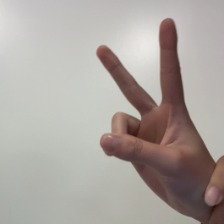

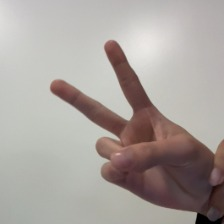

Label: Lizard


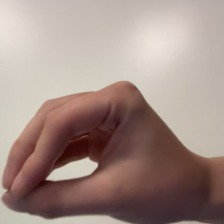

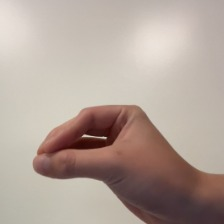

Label: None


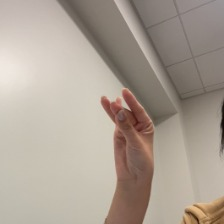

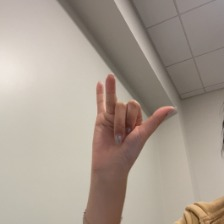

Label: Paper


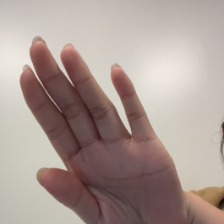

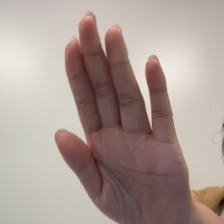

Label: Spock


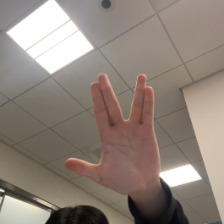

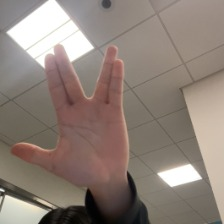

Label: Rock


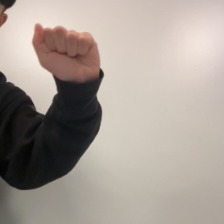

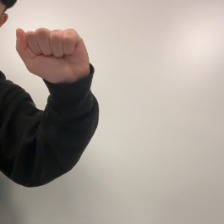

In [9]:
for i in range(6):
  label_dir = os.path.join(dataset_path, labels[i])
  print(f'Label: {labels[i]}')

  for j in range(1,3): # show 2 different examples
    pathimage = os.path.join(label_dir, f'{j*10}.jpg')
    display(Image(pathimage))

## Split the dataset: 80% for training, 10% for validation, and 10% for testing.

In [10]:
data = gesture_recognizer.Dataset.from_folder( # loading data into a dataset
    dirname=dataset_path,
    hparams=gesture_recognizer.HandDataPreprocessingParams()
)

In [11]:
import torch

In [12]:
split = int(0.6*len(data))
trainSet, restSet = torch.utils.data.random_split(data, [split, len(data)-split])
validSet, testSet = torch.utils.data.random_split(restSet, [.5, .5])

In [13]:
train_data, rest_data = data.split(0.6)
validation_data, test_data = rest_data.split(0.5)

## Training

Training the gesture recognizer on our images for 15 epochs and exporting it to use in Flask later.

In [15]:
hparams = gesture_recognizer.HParams(export_dir="exported_model", epochs = 15)
model_options = gesture_recognizer.ModelOptions()
model_options.layer_widths.extend([64, 128]) # adding additional layers

options = gesture_recognizer.GestureRecognizerOptions(model_options=model_options, hparams=hparams)
model = gesture_recognizer.GestureRecognizer.create(
    train_data=train_data,
    validation_data=validation_data,
    options=options
)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hand_embedding (InputLayer  [(None, 128)]             0         
 )                                                               
                                                                 
 batch_normalization (Batch  (None, 128)               512       
 Normalization)                                                  
                                                                 
 re_lu (ReLU)                (None, 128)               0         
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 custom_gesture_recognizer_  (None, 64)                8256      
 0 (Dense)                                                       
                                                             

## Evaluate model performance
Evaluating on test data


In [16]:
loss, acc = model.evaluate(test_data, batch_size=1)
print(f"Test loss:{loss}, Test accuracy:{acc}")

462/462 [==============================] - 10s 9ms/step - loss: 0.1191 - categorical_accuracy: 0.8831
Test loss:0.11905131489038467, Test accuracy:0.8831169009208679


In [17]:
# Export the model
model.export_model()

Using existing files at /tmp/model_maker/gesture_recognizer/palm_detection_full.tflite
Using existing files at /tmp/model_maker/gesture_recognizer/hand_landmark_full.tflite


### Download model to export to flask

In [ ]:
!ls exported_model
files.download('exported_model2/gesture_recognizer.task')